In [321]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [322]:
old_sensor_df = pd.read_csv('WQ_watershed -2018 copy.csv', delimiter=',')
old_sensor_df['period']= old_sensor_df["Date"].map(str) + old_sensor_df["Time"].map(str)

print(old_sensor_df['period'])

tidal_df2018 = pd.read_csv('tidal_2018.csv', delimiter=',')
delayed_tide = pd.read_csv('displaced_tidal.csv', delimiter = ',')
tidal_df2018['ASLVBG02'] = tidal_df2018['ASLVBG02']#.#astype(int)
tidal_df2018['Residual'] = tidal_df2018['Residual']#.astype(int)
tidal_df2018['Cycle'] = tidal_df2018['Cycle'].astype(str)

tidal_df2018['period']= tidal_df2018["Date"].map(str) + tidal_df2018["Time"].map(str)

tide_sensordf = pd.merge(old_sensor_df, tidal_df2018, on = 'period')


0        2018-08-2214:15:00
1        2018-08-2214:20:00
2        2018-08-2214:25:00
3        2018-08-2214:30:00
4        2018-08-2214:35:00
5        2018-08-2214:40:00
6        2018-08-2214:45:00
7        2018-08-2214:50:00
8        2018-08-2214:55:00
9        2018-08-2215:00:00
10       2018-08-2215:05:00
11       2018-08-2215:10:00
12       2018-08-2215:15:00
13       2018-08-2215:20:00
14       2018-08-2215:25:00
15       2018-08-2215:30:00
16       2018-08-2215:35:00
17       2018-08-2215:40:00
18       2018-08-2215:45:00
19       2018-08-2215:50:00
20       2018-08-2215:55:00
21       2018-08-2216:00:00
22       2018-08-2216:05:00
23       2018-08-2216:10:00
24       2018-08-2216:15:00
25       2018-08-2216:20:00
26       2018-08-2216:25:00
27       2018-08-2216:30:00
28       2018-08-2216:35:00
29       2018-08-2216:40:00
                ...        
24709     2018-11-169:25:00
24710     2018-11-169:30:00
24711     2018-11-169:35:00
24712     2018-11-169:40:00
24713     2018-11-16

In [323]:
def maxTidalVals(dataframe):
    np_arr = dataframe.values
    np_arr = np_arr.tolist()
    
    peaks, _= find_peaks(np_arr) #find max value of a tide

    peaks = peaks.tolist()
    pvals = []
    
    for i in range(len(peaks)):
        pvals.append(np_arr[peaks[i]])
    
    peaks_df = pd.DataFrame()
    peaks_df['yvals'] = pvals 
    peaks_df['xvals'] = peaks
    
    A= peaks_df.join(dataframe, how='outer')
    
    i=0
    for j in range(len(np_arr)):
        if i > len(peaks)-1:
            break
        if j <= peaks[i]:
            np_arr[j]=pvals[i]
        else:
            i=i+1
            
    df = pd.DataFrame({'maxTidalVals':np_arr})
    
    return df
    
df_arr = maxTidalVals(tidal_df2018['Residual'])
print(type(df_arr))
print(type(tidal_df2018))

final = pd.concat([df_arr,tidal_df2018], axis=1)


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [372]:
def outlierReduction(dirty_data, thresh):
    outliers = []
    outliers = dirty_data.rolling(window=3, center=True).median()
    difference = np.abs(dirty_data - outliers)
    outlier_idx = []
    vals = []
    for i in range(len(dirty_data)):    
        difference = np.abs(dirty_data[i] - outliers[i])
        if difference > threshold:
            outlier_idx.append(i)
            vals.append(dirty_data[i])

    return dirty_data.drop(outlier_idx), outlier_idx, vals
    

threshold = 75  
clean_conductivity, o1, v1 = outlierReduction(tidal_sensordf['Cond µS/cm'],threshold)
clean_turbidity, o2, v2 = outlierReduction(tidal_sensordf['Turbidity FNU'], threshold)

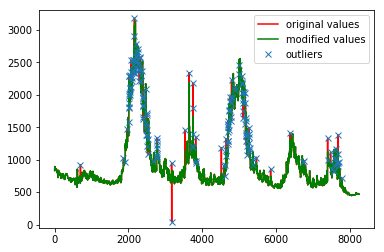

In [373]:
tidal_sensordf = pd.merge(old_sensor_df, final, on= 'period',how= 'inner')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tidal_sensordf['Cond µS/cm'], 'r', label = 'original values')
ax.plot(clean_conductivity, 'g', label = 'modified values')
ax.plot(o1,v1 , 'x', label = 'outliers')
#ax.plot(tidal_sensordf['Turbidity FNU'], 'g')
#ax.set_xlim([0,7000])
ax.set_ylim([-50,3300])
ax.legend(loc="upper right")



fig.savefig('outliers.png')

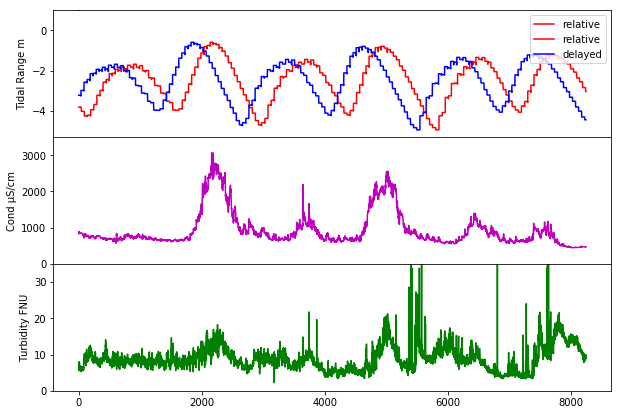

In [370]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10,7))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)

# Plot each graph, and manually set the y tick values
axs[0].plot(delayed_tide,'r', label = "relative")
axs[0].plot(tidal_sensordf['maxTidalVals'], 'b', label = "delayed")
axs[0].set_ylabel('Tidal Range m')
axs[0].set_ylim(-5.3, 1)
axs[0].legend(loc="upper right")



axs[1].plot(clean_conductivity, 'm')
axs[1].set_ylabel('Cond µS/cm')
axs[1].set_ylim(0, 3500)

axs[2].plot(clean_turbidity, 'g')
#axs[2].set_yticks(np.arange(-0.9, 1.0, 0.4))
axs[2].set_ylabel('Turbidity FNU')
axs[2].set_ylim(0, 35)

fig.savefig('sensor_vs_tide.png')

In [296]:
tidal_sensordf.corr(method = 'pearson')
print((delayed_tide.iloc[:,1]))

0      -3.81
1      -3.81
2      -3.81
3      -3.81
4      -3.81
5      -3.81
6      -3.81
7      -3.81
8      -3.81
9      -3.81
10     -3.81
11     -3.81
12     -3.81
13     -3.81
14     -3.81
15     -3.81
16     -3.81
17     -3.81
18     -3.81
19     -3.81
20     -3.81
21     -3.81
22     -3.81
23     -3.81
24     -3.81
25     -3.81
26     -3.81
27     -3.81
28     -3.81
29     -3.81
        ... 
8216   -2.84
8217   -2.84
8218   -2.84
8219   -2.84
8220   -2.84
8221   -2.84
8222   -2.84
8223   -2.84
8224   -2.84
8225   -2.84
8226   -2.84
8227   -2.84
8228   -2.84
8229   -2.84
8230   -2.84
8231   -2.84
8232   -2.84
8233   -2.84
8234   -2.84
8235   -2.84
8236   -2.84
8237   -2.84
8238   -2.84
8239   -2.92
8240   -3.04
8241   -3.04
8242   -3.04
8243   -3.04
8244   -3.04
8245   -3.04
Name: -3.81, Length: 8246, dtype: float64


In [314]:
newdf = pd.DataFrame()
newdf['Delayed Tide'] = tidal_sensordf['maxTidalVals']
newdf['Relative Tide'] = delayed_tide.iloc[:,1]
newdf['Conductivity'] = clean_conductivity.to_frame()
newdf['Turbidity'] = clean_turbidity.to_frame()
A = newdf.corr()
print(A)


               Delayed Tide  Relative Tide  Conductivity  Turbidity
Delayed Tide       1.000000       0.158589      0.122910   0.104305
Relative Tide      0.158589       1.000000      0.582704   0.386226
Conductivity       0.122910       0.582704      1.000000   0.333676
Turbidity          0.104305       0.386226      0.333676   1.000000
